In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [5]:
#from _future_ import printfunction,unicode literals
import json
import requests
import xlrd
import openpyxl

In [6]:
bj = pd.read_csv("data/Key-Word Beijing Air Quality_senti.csv")
#X=dataset.iloc[:,:-1].values
#Y=dataset.iloc[:,3].values
bj

,time,positive,negative
0,2019/5/1,0.939747,0.060253
1,2019/5/1,0.052578,0.947422
2,2019/5/1,0.946240,0.053760
3,2019/5/1,0.946240,0.053760
4,2019/5/1,0.035910,0.964090
...,...,...,...
1068,2019/4/15,0.875910,0.124090
1069,2019/4/15,0.986012,0.013988
1070,2019/4/15,0.998533,0.001467
1071,2019/4/15,0.931758,0.068242


In [7]:
bj_senti = pd.read_csv("data/Key-Word Beijing Air Quality_senti.csv")

bj_senti

,time,positive,negative
0,2019/5/1,0.939747,0.060253
1,2019/5/1,0.052578,0.947422
2,2019/5/1,0.946240,0.053760
3,2019/5/1,0.946240,0.053760
4,2019/5/1,0.035910,0.964090
...,...,...,...
1068,2019/4/15,0.875910,0.124090
1069,2019/4/15,0.986012,0.013988
1070,2019/4/15,0.998533,0.001467
1071,2019/4/15,0.931758,0.068242


In [8]:
bj_senti_mean = bj_senti.mean()
bj_senti_mean

positive    0.664598
negative    0.335402
dtype: float64

In [9]:
bj_senti_var = bj_senti.var()
bj_senti_var

positive    0.106816
negative    0.106816
dtype: float64

In [10]:
bj_senti.positive

0       0.939747
1       0.052578
2       0.946240
3       0.946240
4       0.035910
          ...   
1068    0.875910
1069    0.986012
1070    0.998533
1071    0.931758
1072    0.964208
Name: positive, Length: 1073, dtype: float64

bj_senti = bj_senti.set_index('time')
bj_senti.head(50)

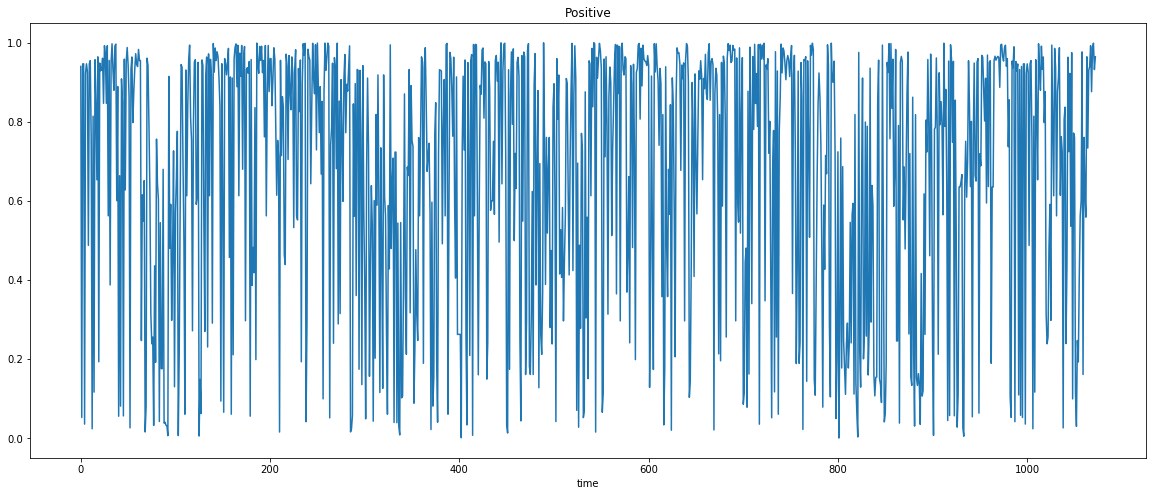

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,8))
plt.plot(bj_senti.positive)
plt.title('Positive')
# plt.ylabel('')
plt.xlabel('time')
plt.grid(False)
plt.show()

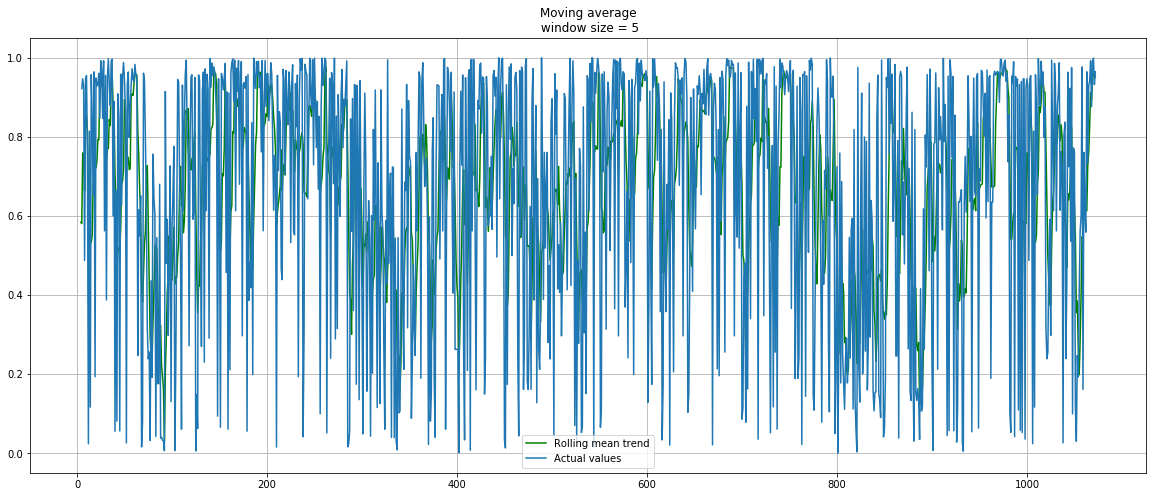

In [12]:
def plot_moving_average(series,window,plot_intervals=False, scale =1.96):
    rolling_mean = series.rolling(window=window).mean()
 
    plt.figure(figsize=(20,8))
    plt.title('Moving average\n window size = {}'.format(window))
    #smaller window, more details; more bigger window, you can see the plot
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    #plt.plot(lwd = 1)

    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

#Smooth by the previous 5 days (by week)
plot_moving_average(bj_senti.positive, 5)

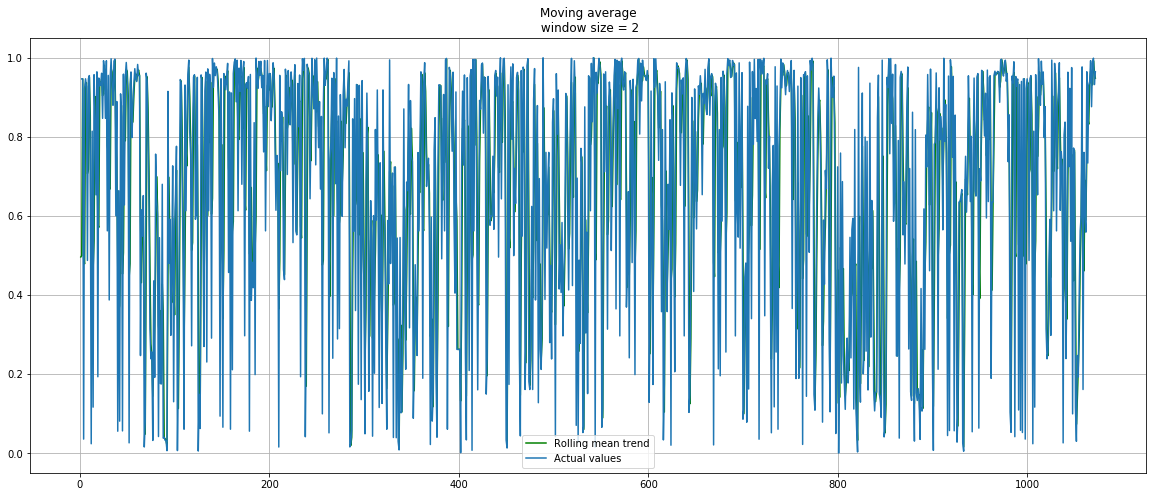

In [13]:
plot_moving_average(bj_senti.positive, 2)

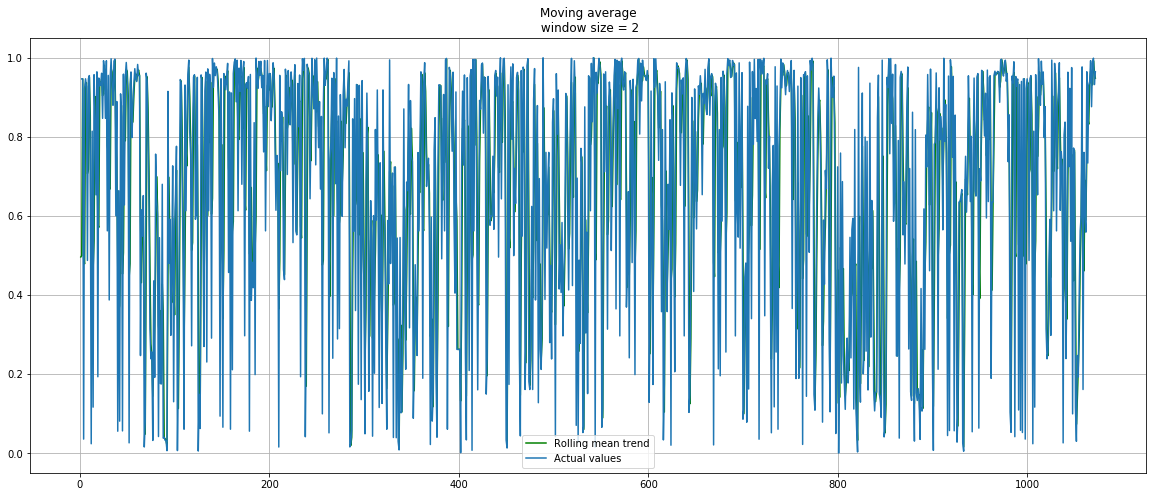

In [14]:
plot_moving_average(bj_senti.positive, 2, plot_intervals=False)

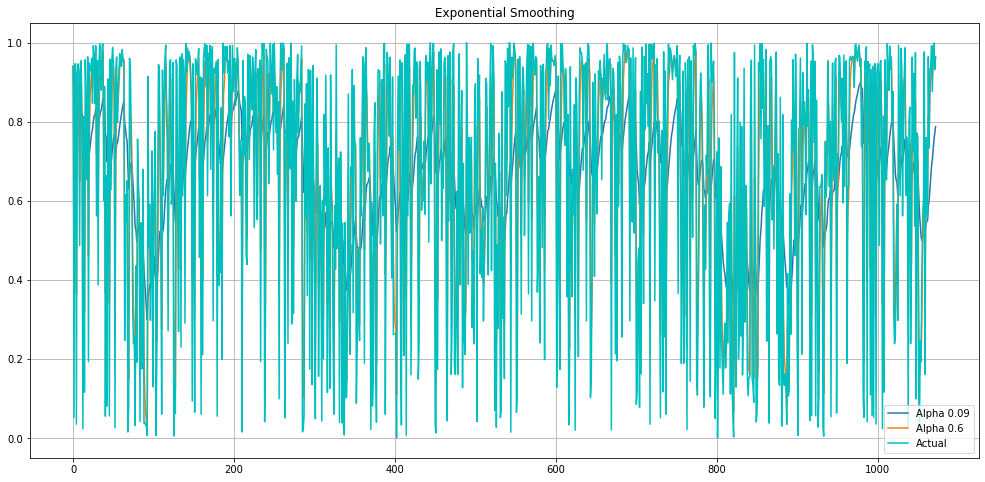

In [15]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);
        
plot_exponential_smoothing(bj_senti.positive, [0.09, 0.6])

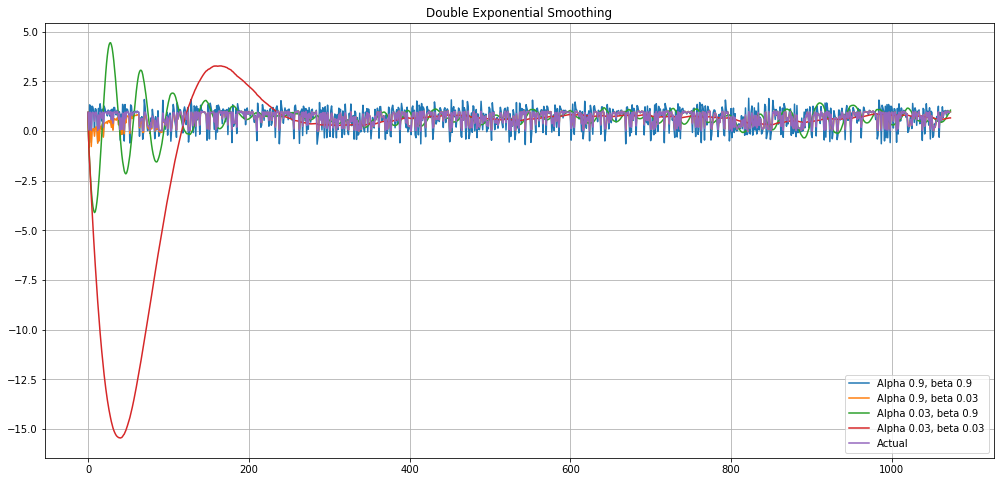

In [16]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

plot_double_exponential_smoothing(bj_senti.positive, alphas=[0.9, 0.03], betas=[0.9, 0.03])

In [17]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [18]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Positive Value')
    plt.plot(predicted, color='blue',label='Predicted Positive Value')
    plt.title('Positive Value Prediction')
    plt.xlabel('Time')
    plt.ylabel('Positive Value')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))


In [19]:
# First, we get the data
dataset = pd.read_csv('data/Key-Word Beijing Air Quality_senti.csv', index_col='time', parse_dates=['time'])
dataset = dataset.sort_values(by="time" , ascending=True)
dataset

,positive,negative
time,,
2019-04-02,0.928410,0.071590
2019-04-02,0.952182,0.047818
2019-04-02,0.936633,0.063367
2019-04-02,0.945986,0.054014
2019-04-02,0.109542,0.890458
...,...,...
2019-05-01,0.946350,0.053650
2019-05-01,0.921714,0.078286
2019-05-01,0.035910,0.964090


In [20]:
dataset["newindex"] = range(len(dataset))
dataset

,positive,negative,newindex
time,,,
2019-04-02,0.928410,0.071590,0
2019-04-02,0.952182,0.047818,1
2019-04-02,0.936633,0.063367,2
2019-04-02,0.945986,0.054014,3
2019-04-02,0.109542,0.890458,4
...,...,...,...
2019-05-01,0.946350,0.053650,1068
2019-05-01,0.921714,0.078286,1069
2019-05-01,0.035910,0.964090,1070


In [21]:
dataset = dataset.set_index('newindex')
dataset

,positive,negative
newindex,,
0,0.928410,0.071590
1,0.952182,0.047818
2,0.936633,0.063367
3,0.945986,0.054014
4,0.109542,0.890458
...,...,...
1068,0.946350,0.053650
1069,0.921714,0.078286
1070,0.035910,0.964090


In [22]:
# Checking for missing values
training_set = dataset[:800].iloc[:,:-1].values
test_set = dataset[800:].iloc[:,:-1].values
training_set.shape

(800, 1)

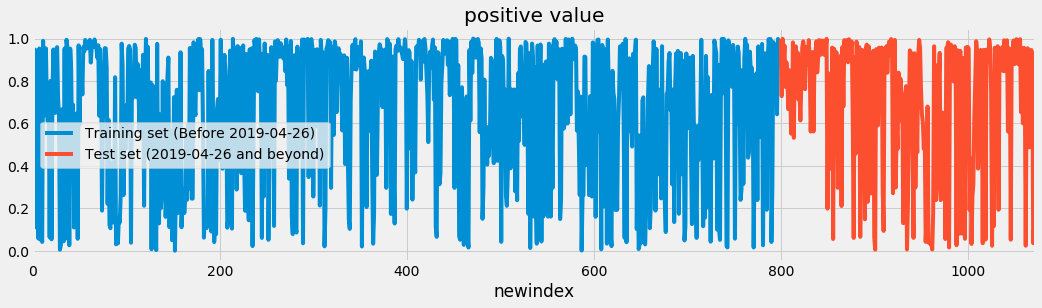

In [23]:
dataset["positive"][:800].plot(figsize=(16,4),legend=True)
dataset["positive"][800:].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2019-04-26)','Test set (2019-04-26 and beyond)'])
plt.title('positive value')
plt.show()

In [24]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(30,799):
    X_train.append(training_set[i-30:i,0])
    y_train.append(training_set[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [25]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [26]:
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
769/769 [==============================] - 2s 3ms/step - loss: 0.1664
Epoch 2/50
769/769 [==============================] - 1s 1ms/step - loss: 0.1254
Epoch 3/50
769/769 [==============================] - 1s 1ms/step - loss: 0.1255
Epoch 4/50
769/769 [==============================] - 1s 1ms/step - loss: 0.1151
Epoch 5/50
769/769 [==============================] - 1s 1ms/step - loss: 0.1238
Epoch 6/50
769/769 [==============================] - 1s 1ms/step - loss: 0.1177
Epoch 7/50
769/769 [==============================] - 1s 1ms/step - loss: 0.1210
Epoch 8/50
769/769 [==============================] - 1s 1ms/step - loss: 0.1138
Epoch 9/50
769/769 [==============================] - 1s 1ms/step - loss: 0.1150
Epoch 10/50
769/769 [==============================] - 1s 1ms/step - loss: 0.1186
Epoch 11/50
769/769 [==============================] - 1s 1ms/step - loss: 0.1100
Epoch 12/50
769/769 [==============================] - 1s 1ms/step - loss: 0.1131
Epoch 13/50
769/769 [====

In [27]:
sc = MinMaxScaler(feature_range=(0,1))
training_set = sc.fit_transform(training_set)
training_set

array([[9.28571675e-01],
       [9.52365425e-01],
       [9.36802459e-01],
       [9.46164065e-01],
       [1.08953919e-01],
       [9.32177244e-01],
       [5.75002663e-02],
       [9.53463937e-01],
       [5.23236184e-02],
       [1.03452792e-01],
       [4.13172931e-02],
       [9.89627562e-01],
       [6.36080732e-01],
       [8.40826408e-01],
       [9.54119224e-01],
       [6.97188975e-01],
       [6.09293249e-01],
       [7.50551517e-01],
       [6.30271917e-02],
       [8.00945341e-01],
       [5.37553905e-02],
       [7.49058039e-01],
       [9.48501573e-01],
       [6.63297274e-01],
       [6.49866487e-01],
       [9.51178016e-01],
       [9.59795049e-01],
       [7.19128710e-01],
       [6.34818276e-01],
       [4.62917490e-03],
       [2.75771953e-02],
       [6.66354254e-01],
       [6.36080732e-01],
       [4.42632248e-02],
       [9.53479434e-01],
       [5.68616319e-02],
       [9.94673160e-01],
       [9.59795049e-01],
       [7.47942967e-01],
       [2.56150939e-02],


In [28]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["positive"][:800],dataset["positive"][800:]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 30:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)
inputs

array([[0.71430767],
       [0.01517177],
       [0.43859623],
       [0.80469015],
       [0.83704179],
       [0.23885711],
       [0.96329379],
       [0.72422637],
       [0.92241723],
       [0.53556805],
       [0.97495717],
       [0.02566991],
       [0.70459739],
       [0.93078315],
       [0.88188984],
       [0.19293644],
       [0.89450522],
       [0.99724422],
       [0.96843473],
       [0.9982602 ],
       [0.04118105],
       [0.29627435],
       [0.9834207 ],
       [0.96437205],
       [0.95594658],
       [0.9561499 ],
       [0.64310954],
       [0.9984935 ],
       [0.91009356],
       [0.87063541],
       [0.99484869],
       [0.72890147],
       [0.99900552],
       [0.87944055],
       [0.96746663],
       [0.77243766],
       [0.88894723],
       [0.83566565],
       [0.66777493],
       [0.85136796],
       [0.82563382],
       [0.55176927],
       [0.56143874],
       [0.98221122],
       [0.53225608],
       [0.92241723],
       [0.96396269],
       [0.830

In [ ]:
inputs[1:1,0]

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(30,303):
    X_test.append(inputs[i-30:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_positive_value = regressor.predict(X_test)
predicted_positive_value = sc.inverse_transform(predicted_positive_value)

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_positive_value)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_positive_value)